


# Model 3 Fine Tuning


**Name:** Kavin Fidel <br>

**ID.:** 210200007 <br>
**Model** ConvNeXtTiny


In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(41)

import numpy as np
np.random.seed(41)

import matplotlib.pyplot as plt
%matplotlib inline

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load("/content/drive/MyDrive/Deep Learning/Models/X_train3_std.npy")
X_test_std = load("/content/drive/MyDrive/Deep Learning/Models/X_test3_std.npy")

y_train = load("/content/drive/MyDrive/Deep Learning/Models/y_train3.npy")
y_test = load("/content/drive/MyDrive/Deep Learning/Models/y_test3.npy")


In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (487, 299, 299, 3)
X_test_std_shape: (163, 299, 299, 3)


## Load the model from Model1_TL
- We apply fine tuning on this model

In [7]:
from keras import layers
class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

model3_FT = keras.models.load_model("/content/drive/MyDrive/Deep Learning/Models/Model3_TL.h5",custom_objects={"LayerScale": LayerScale} )
model3_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, None, None, 3)        0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, None, None, 96)       4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                              

In [8]:
tot_layers = len(model3_FT.layers)
freeze_layer = round(tot_layers * 0.25)

for layer in model3_FT.layers[:freeze_layer]:
  layer.trainable = False

for layer in model3_FT.layers[freeze_layer:]:
  layer.trainable = True


In [ ]:
model3_FT.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks3_FT = [
             keras.callbacks.ModelCheckpoint("bestFT3.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history3_FT = model3_FT.fit(x = X_train_std, y = y_train, epochs=10,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks3_FT)

Epoch 1/10
28/28 [==============================] - 57s 764ms/step - loss: 0.2096 - accuracy: 0.9247 - val_loss: 3.1661 - val_accuracy: 0.2653
Epoch 2/10
28/28 [==============================] - 12s 445ms/step - loss: 0.0653 - accuracy: 0.9726 - val_loss: 1.3311 - val_accuracy: 0.6122
Epoch 3/10
28/28 [==============================] - 13s 454ms/step - loss: 0.0144 - accuracy: 0.9977 - val_loss: 0.4986 - val_accuracy: 0.7959
Epoch 4/10
28/28 [==============================] - 12s 439ms/step - loss: 0.0043 - accuracy: 0.9977 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 5/10
28/28 [==============================] - 12s 412ms/step - loss: 0.0432 - accuracy: 0.9932 - val_loss: 3.0332 - val_accuracy: 0.5510
Epoch 6/10
28/28 [==============================] - 11s 410ms/step - loss: 0.0848 - accuracy: 0.9772 - val_loss: 1.6856 - val_accuracy: 0.5918
Epoch 7/10
28/28 [==============================] - 12s 433ms/step - loss: 0.1087 - accuracy: 0.9726 - val_loss: 3.0498 - val_accuracy: 0.4082

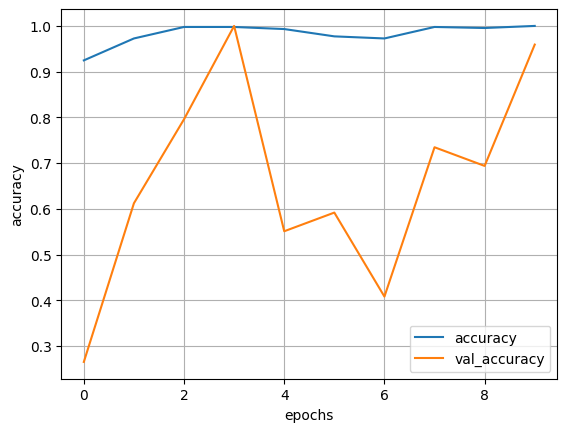

In [ ]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history3_FT.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [ ]:
testLoss_FT, testAccuracy_FT = model3_FT.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

6/6 [==============================] - 7s 623ms/step - loss: 0.3779 - accuracy: 0.8589
Test-loss: 0.377911, Test-accuracy: 0.858896


In [ ]:


model3_FT.load_weights("bestFT3.h5")

testLoss_FT, testAccuracy_FT = model3_FT.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

6/6 [==============================] - 2s 313ms/step - loss: 0.0293 - accuracy: 0.9939
Test-loss: 0.029259, Test-accuracy: 0.993865


## Prediction of testing sample and inferences

In [ ]:
y_proba = model3_FT.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

In [ ]:


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [ ]:


from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

In [ ]:

model2_FT.save("/content/drive/MyDrive/Deep Learning/Models/Fine_Tuned/Model3_FT.h5")